In [1]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score, average_precision_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import cv2
import os
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [2]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [36]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [37]:
corr_matrix = tabular_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

tabular_features_reduced = tabular_features.drop(to_drop, axis=1)
print(f"Dropped {len(to_drop)} redundant features.")

Dropped 234 redundant features.


In [38]:
corr_matrix = tabular_features.corr().abs()
print(corr_matrix)

                                                  log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity  \
log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity                                          1.000000   
log-sigma-1-0-mm-3D_ngtdm_Coarseness                                                      0.918320   
minor_axis_length                                                                         0.860863   
area                                                                                      0.842361   
log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity                                          0.880240   
...                                                                                            ...   
log-sigma-2-0-mm-3D_glcm_MCC                                                              0.191426   
LBP_hist_bin_7                                                                            0.326757   
log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis                                    

In [39]:
# top50
selector = SelectKBest(score_func=f_classif, k=50)
x_tabular_selected = selector.fit_transform(tabular_features_reduced, labels)
selected_names = tabular_features_reduced.columns[selector.get_support()]
print("Top 10 features:", selected_names[:10].tolist())

Top 10 features: ['log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-1-0-mm-3D_ngtdm_Coarseness', 'minor_axis_length', 'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity', 'perimeter', 'wavelet-H_gldm_DependenceNonUniformity', 'log-sigma-3-0-mm-3D_ngtdm_Coarseness', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity', 'wavelet-H_glrlm_GrayLevelNonUniformity']


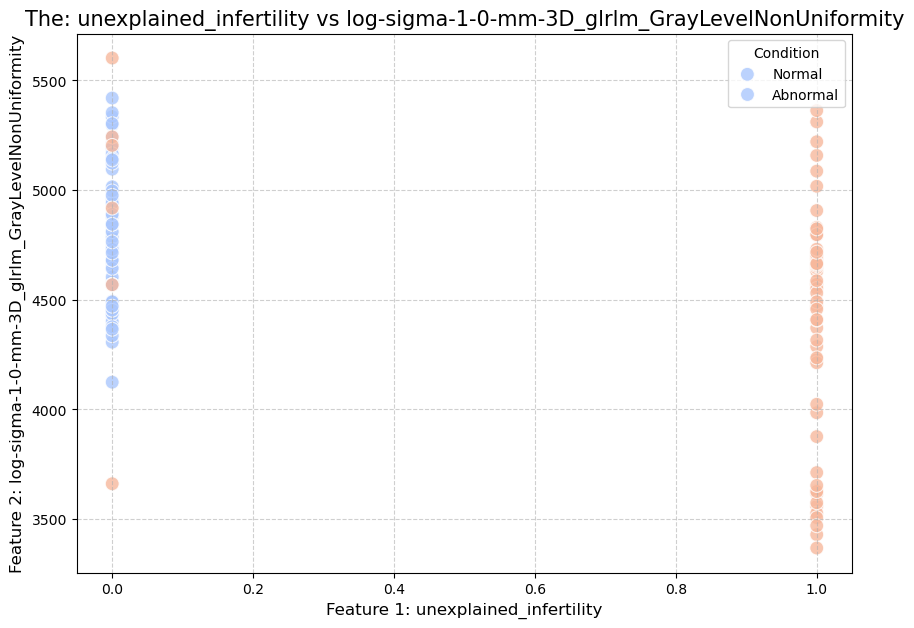

In [ ]:

# check_df = pd.DataFrame(x_tabular_selected, columns=selected_names)
# check_df['TARGET_LABEL'] = labels.values
# correlations = check_df.corr()['TARGET_LABEL'].abs().sort_values(ascending=False)

# top_10_names = correlations.iloc[1:11].index

# f1 = correlations.index[1]
# f2 = correlations.index[2] 

# plt.figure(figsize=(10, 7))
# sns.scatterplot(x=check_df[f1], y=check_df[f2], hue=check_df['TARGET_LABEL'], 
#                 palette='coolwarm', s=100, alpha=0.8)

# plt.title(f'The: {f1} vs {f2}', fontsize=15)
# plt.xlabel(f'Feature 1: {f1}', fontsize=12)
# plt.ylabel(f'Feature 2: {f2}', fontsize=12)
# plt.legend(title='Condition', labels=['Normal', 'Abnormal'])
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()
# # removing unexplained infertility!!

In [42]:
Scaler = StandardScaler()
x_tabular_final = Scaler.fit_transform(x_tabular_selected)
y = labels.values

In [43]:
height, width = 256, 256 
batch_size=16

In [44]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [45]:
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular_final, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [46]:
# y = labels.values if hasattr(labels, "values") else labels

# X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
#     X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
# )
# print("Training samples:", X_img_train.shape[0])
# print("Validation samples:", X_img_val.shape[0])


In [47]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular_final.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 85, 85,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 85, 85,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      6,528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 125,441 (490.00 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 704 (2.75 KB)

In [48]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [49]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4746 - loss: 0.7404
Epoch 1: val_loss improved from None to 0.72623, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - accuracy: 0.4659 - loss: 0.7560 - val_accuracy: 0.5500 - val_loss: 0.7262
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5669 - loss: 0.7441
Epoch 2: val_loss improved from 0.72623 to 0.72045, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - accuracy: 0.4886 - loss: 0.7784 - val_accuracy: 0.5000 - val_loss: 0.7205
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7259 - loss: 0.6172
Epoch 3: val_loss improved from 0.72045 to 0.71379, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.6818 - loss: 0.6522 - val_accuracy: 0.5000 - val_loss: 0.7138
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5439 - loss: 0.7526
Epoch 4: val_loss improved from 0.71379 to 0.70829, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.5455 - loss: 0.7396 - val_accuracy: 0.5500 - val_loss: 0.7083
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5868 - loss: 0.7122
Epoch 5: val_loss improved from 0.70829 to 0.70050, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5568 - loss: 0.7196 - val_accuracy: 0.5500 - val_loss: 0.7005
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6329 - loss: 0.6928
Epoch 6: val_loss improved from 0.70050 to 0.69352, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.5795 - loss: 0.7159 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6281 - loss: 0.6775
Epoch 7: val_loss improved from 0.69352 to 0.68528, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6023 - loss: 0.6834 - val_accuracy: 0.6500 - val_loss: 0.6853
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6116 - loss: 0.6994
Epoch 8: val_loss improved from 0.68528 to 0.67986, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5227 - loss: 0.7310 - val_accuracy: 0.6500 - val_loss: 0.6799
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6128 - loss: 0.6919
Epoch 9: val_loss improved from 0.67986 to 0.67464, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.6591 - loss: 0.6694 - val_accuracy: 0.6500 - val_loss: 0.6746
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6098 - loss: 0.6799
Epoch 10: val_loss improved from 0.67464 to 0.66783, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5909 - loss: 0.6739 - val_accuracy: 0.7000 - val_loss: 0.6678
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6442 - loss: 0.6862
Epoch 11: val_loss improved from 0.66783 to 0.66126, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.6364 - loss: 0.6809 - val_accuracy: 0.7000 - val_loss: 0.6613
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7281 - loss: 0.6182
Epoch 12: val_loss improved from 0.66126 to 0.65535, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.6818 - loss: 0.6314 - val_accuracy: 0.6500 - val_loss: 0.6554
Epoch 13/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5664 - loss: 0.6946
Epoch 13: val_loss improved from 0.65535 to 0.64846, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.5682 - loss: 0.7082 - val_accuracy: 0.7000 - val_loss: 0.6485
Epoch 14/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5158 - loss: 0.7612
Epoch 14: val_loss improved from 0.64846 to 0.64214, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.6705 - loss: 0.6662 - val_accuracy: 0.7000 - val_loss: 0.6421
Epoch 15/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6714 - loss: 0.6483
Epoch 15: val_loss improved from 0.64214 to 0.63651, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.6250 - loss: 0.6679 - val_accuracy: 0.7000 - val_loss: 0.6365
Epoch 16/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7098 - loss: 0.6685
Epoch 16: val_loss improved from 0.63651 to 0.63004, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.6932 - loss: 0.6541 - val_accuracy: 0.7000 - val_loss: 0.6300
Epoch 17/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7331 - loss: 0.6341
Epoch 17: val_loss improved from 0.63004 to 0.62460, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step - accuracy: 0.6932 - loss: 0.6400 - val_accuracy: 0.7000 - val_loss: 0.6246
Epoch 18/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5989 - loss: 0.7150
Epoch 18: val_loss improved from 0.62460 to 0.62009, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.5909 - loss: 0.7013 - val_accuracy: 0.7000 - val_loss: 0.6201
Epoch 19/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5993 - loss: 0.6673
Epoch 19: val_loss improved from 0.62009 to 0.61441, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.6136 - loss: 0.6600 - val_accuracy: 0.7000 - val_loss: 0.6144
Epoch 20/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7117 - loss: 0.6616
Epoch 20: val_loss improved from 0.61441 to 0.60807, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.6818 - loss: 0.6462 - val_accuracy: 0.7500 - val_loss: 0.6081
Epoch 21/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6028 - loss: 0.6495
Epoch 21: val_loss improved from 0.60807 to 0.60113, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.6591 - loss: 0.6058 - val_accuracy: 0.8000 - val_loss: 0.6011
Epoch 22/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5820 - loss: 0.6862
Epoch 22: val_loss improved from 0.60113 to 0.59813, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.6250 - loss: 0.6560 - val_accuracy: 0.8000 - val_loss: 0.5981
Epoch 23/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6424 - loss: 0.6401
Epoch 23: val_loss improved from 0.59813 to 0.59372, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.6705 - loss: 0.6346 - val_accuracy: 0.8000 - val_loss: 0.5937
Epoch 24/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6571 - loss: 0.6491
Epoch 24: val_loss improved from 0.59372 to 0.58933, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.6364 - loss: 0.6548 - val_accuracy: 0.8000 - val_loss: 0.5893
Epoch 25/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6623 - loss: 0.6773
Epoch 25: val_loss improved from 0.58933 to 0.58763, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.6364 - loss: 0.6660 - val_accuracy: 0.8000 - val_loss: 0.5876
Epoch 26/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7334 - loss: 0.6210
Epoch 26: val_loss improved from 0.58763 to 0.58366, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.7273 - loss: 0.6013 - val_accuracy: 0.8000 - val_loss: 0.5837
Epoch 27/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7167 - loss: 0.6232
Epoch 27: val_loss improved from 0.58366 to 0.57600, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.7500 - loss: 0.6015 - val_accuracy: 0.8000 - val_loss: 0.5760
Epoch 28/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5194 - loss: 0.6763
Epoch 28: val_loss improved from 0.57600 to 0.56999, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.6364 - loss: 0.6390 - val_accuracy: 0.7500 - val_loss: 0.5700
Epoch 29/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7681 - loss: 0.5627
Epoch 29: val_loss improved from 0.56999 to 0.56649, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.7045 - loss: 0.6325 - val_accuracy: 0.7000 - val_loss: 0.5665
Epoch 30/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5772 - loss: 0.6563
Epoch 30: val_loss improved from 0.56649 to 0.56107, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.6023 - loss: 0.6572 - val_accuracy: 0.7000 - val_loss: 0.5611
Epoch 31/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7374 - loss: 0.5782
Epoch 31: val_loss improved from 0.56107 to 0.55242, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7500 - loss: 0.6071 - val_accuracy: 0.8000 - val_loss: 0.5524
Epoch 32/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7708 - loss: 0.5756
Epoch 32: val_loss improved from 0.55242 to 0.54723, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.7386 - loss: 0.5852 - val_accuracy: 0.8000 - val_loss: 0.5472
Epoch 33/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7777 - loss: 0.5526
Epoch 33: val_loss did not improve from 0.54723
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.7614 - loss: 0.5729 - val_accuracy: 0.7500 - val_loss: 0.5487
Epoch 34/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6554 - loss: 0.6515
Epoch 34: val_loss improved from 0.54723 to 0.54100, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.7045 - loss: 0.6040 - val_accuracy: 0.8000 - val_loss: 0.5410
Epoch 35/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7118 - loss: 0.5725
Epoch 35: val_loss improved from 0.54100 to 0.53707, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.7727 - loss: 0.5548 - val_accuracy: 0.8000 - val_loss: 0.5371
Epoch 36/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7469 - loss: 0.6407
Epoch 36: val_loss improved from 0.53707 to 0.52746, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.7614 - loss: 0.6097 - val_accuracy: 0.8000 - val_loss: 0.5275
Epoch 37/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7257 - loss: 0.5566
Epoch 37: val_loss improved from 0.52746 to 0.51548, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7273 - loss: 0.5947 - val_accuracy: 0.8500 - val_loss: 0.5155
Epoch 38/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7452 - loss: 0.5147
Epoch 38: val_loss improved from 0.51548 to 0.50987, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.7500 - loss: 0.5443 - val_accuracy: 0.8500 - val_loss: 0.5099
Epoch 39/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8017 - loss: 0.4876
Epoch 39: val_loss improved from 0.50987 to 0.50904, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.7500 - loss: 0.5513 - val_accuracy: 0.8500 - val_loss: 0.5090
Epoch 40/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7657 - loss: 0.5505
Epoch 40: val_loss improved from 0.50904 to 0.50608, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7159 - loss: 0.5826 - val_accuracy: 0.8500 - val_loss: 0.5061
Epoch 41/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7339 - loss: 0.5656
Epoch 41: val_loss did not improve from 0.50608
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7500 - loss: 0.5743 - val_accuracy: 0.6500 - val_loss: 0.5202
Epoch 42/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6688 - loss: 0.6246
Epoch 42: val_loss did not improve from 0.50608
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7273 - loss: 0.5818 - val_accuracy: 0.6500 - val_loss: 0.5325
Epoch 43/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6128 - loss: 0.6361
Epoch 43: val_loss improved from 0.50608 to 0.50159, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.7045 - loss: 0.5845 - val_accuracy: 0.8500 - val_loss: 0.5016
Epoch 44/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7407 - loss: 0.5608
Epoch 44: val_loss did not improve from 0.50159
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7273 - loss: 0.5892 - val_accuracy: 0.7000 - val_loss: 0.5221
Epoch 45/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8051 - loss: 0.5003
Epoch 45: val_loss did not improve from 0.50159
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7273 - loss: 0.5636 - val_accuracy: 0.6500 - val_loss: 0.5325
Epoch 46/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6910 - loss: 0.6349
Epoch 46: val_loss did not improve from 0.50159
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.7386 - loss: 0.5452 - val_accuracy: 0.6500 - val_loss: 0.5500
Epoch 47/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7608 - loss: 0.5710
Epoch 47: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.7955 - loss: 0.5072 - val_accuracy: 0.8000 - val_loss: 0.5015
Epoch 50/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7720 - loss: 0.6015
Epoch 50: val_loss improved from 0.50153 to 0.48962, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.7727 - loss: 0.5629 - val_accuracy: 0.8000 - val_loss: 0.4896
Epoch 51/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7798 - loss: 0.5288
Epoch 51: val_loss improved from 0.48962 to 0.47682, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8409 - loss: 0.4810 - val_accuracy: 0.8500 - val_loss: 0.4768
Epoch 52/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7436 - loss: 0.5777
Epoch 52: val_loss improved from 0.47682 to 0.47322, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.7500 - loss: 0.5833 - val_accuracy: 0.8500 - val_loss: 0.4732
Epoch 53/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7363 - loss: 0.5897
Epoch 53: val_loss improved from 0.47322 to 0.46824, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7841 - loss: 0.5402 - val_accuracy: 0.8500 - val_loss: 0.4682
Epoch 54/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8247 - loss: 0.4470
Epoch 54: val_loss improved from 0.46824 to 0.46191, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7614 - loss: 0.5121 - val_accuracy: 0.9000 - val_loss: 0.4619
Epoch 55/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7454 - loss: 0.5495
Epoch 55: val_loss improved from 0.46191 to 0.45863, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.7727 - loss: 0.5139 - val_accuracy: 0.9000 - val_loss: 0.4586
Epoch 56/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7029 - loss: 0.5523
Epoch 56: val_loss did not improve from 0.45863
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.7386 - loss: 0.5596 - val_accuracy: 0.8000 - val_loss: 0.4805
Epoch 57/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7749 - loss: 0.5416
Epoch 57: val_loss did not improve from 0.45863
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.7727 - loss: 0.5399 - val_accuracy: 0.8500 - val_loss: 0.4588
Epoch 58/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8277 - loss: 0.4794
Epoch 58: val_loss improved from 0.45863 to 0.45562, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8182 - loss: 0.4787 - val_accuracy: 0.8500 - val_loss: 0.4556
Epoch 59/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7876 - loss: 0.4926
Epoch 59: val_loss improved from 0.45562 to 0.45272, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.7273 - loss: 0.5202 - val_accuracy: 0.8500 - val_loss: 0.4527
Epoch 60/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7610 - loss: 0.5116
Epoch 60: val_loss did not improve from 0.45272
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7727 - loss: 0.5187 - val_accuracy: 0.8500 - val_loss: 0.4655
Epoch 61/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7814 - loss: 0.5426
Epoch 61: val_loss did not improve from 0.45272
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.7841 - loss: 0.5536 - val_accuracy: 0.7500 - val_loss: 0.4900
Epoch 62/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7234 - loss: 0.5171
Epoch 62: val_loss did not improve from 0.45272
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 484ms/step - accuracy: 0.7955 - loss: 0.4688 - val_accuracy: 0.7000 - val_loss: 0.4910
Epoch 63/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8100 - loss: 0.4847
Epoch 63: val_loss did not improve 

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.8295 - loss: 0.4882 - val_accuracy: 0.8000 - val_loss: 0.4417
Epoch 66/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7378 - loss: 0.5760
Epoch 66: val_loss improved from 0.44172 to 0.42822, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.7500 - loss: 0.5348 - val_accuracy: 0.8500 - val_loss: 0.4282
Epoch 67/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8316 - loss: 0.4443
Epoch 67: val_loss did not improve from 0.42822
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.8068 - loss: 0.4788 - val_accuracy: 0.8500 - val_loss: 0.4309
Epoch 68/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7786 - loss: 0.5319
Epoch 68: val_loss improved from 0.42822 to 0.41976, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - accuracy: 0.7727 - loss: 0.5101 - val_accuracy: 0.8500 - val_loss: 0.4198
Epoch 69/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8281 - loss: 0.4317
Epoch 69: val_loss did not improve from 0.41976
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.8295 - loss: 0.4426 - val_accuracy: 0.8000 - val_loss: 0.4232
Epoch 70/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8299 - loss: 0.4461
Epoch 70: val_loss did not improve from 0.41976
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.7841 - loss: 0.4784 - val_accuracy: 0.7500 - val_loss: 0.4476
Epoch 71/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8637 - loss: 0.4144
Epoch 71: val_loss did not improve from 0.41976
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.8636 - loss: 0.4225 - val_accuracy: 0.7500 - val_loss: 0.4542
Epoch 72/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7516 - loss: 0.4719
Epoch 72: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.7841 - loss: 0.5020 - val_accuracy: 0.8500 - val_loss: 0.4049
Epoch 75/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8262 - loss: 0.4616
Epoch 75: val_loss did not improve from 0.40492
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.7955 - loss: 0.4909 - val_accuracy: 0.8500 - val_loss: 0.4191
Epoch 76/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8011 - loss: 0.4613
Epoch 76: val_loss did not improve from 0.40492
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.8068 - loss: 0.4651 - val_accuracy: 0.8500 - val_loss: 0.4106
Epoch 77/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8672 - loss: 0.4141
Epoch 77: val_loss did not improve from 0.40492
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8409 - loss: 0.4560 - val_accuracy: 0.8000 - val_loss: 0.4180
Epoch 78/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7423 - loss: 0.5036
Epoch 78: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.8523 - loss: 0.4180 - val_accuracy: 0.8500 - val_loss: 0.4012
Epoch 80/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8171 - loss: 0.4351
Epoch 80: val_loss did not improve from 0.40119
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.7841 - loss: 0.4631 - val_accuracy: 0.8500 - val_loss: 0.4109
Epoch 81/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8568 - loss: 0.4708
Epoch 81: val_loss improved from 0.40119 to 0.38552, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.8750 - loss: 0.4430 - val_accuracy: 0.9000 - val_loss: 0.3855
Epoch 82/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8024 - loss: 0.4370
Epoch 82: val_loss did not improve from 0.38552
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - accuracy: 0.8636 - loss: 0.3771 - val_accuracy: 0.8500 - val_loss: 0.3903
Epoch 83/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8897 - loss: 0.3816
Epoch 83: val_loss did not improve from 0.38552
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8523 - loss: 0.4309 - val_accuracy: 0.8500 - val_loss: 0.3887
Epoch 84/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7989 - loss: 0.4802
Epoch 84: val_loss improved from 0.38552 to 0.36519, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 641ms/step - accuracy: 0.8182 - loss: 0.4552 - val_accuracy: 0.9000 - val_loss: 0.3652
Epoch 85/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8045 - loss: 0.4875
Epoch 85: val_loss improved from 0.36519 to 0.34690, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.8409 - loss: 0.4515 - val_accuracy: 0.9000 - val_loss: 0.3469
Epoch 86/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9056 - loss: 0.2951
Epoch 86: val_loss did not improve from 0.34690
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.9205 - loss: 0.3163 - val_accuracy: 0.9000 - val_loss: 0.3808
Epoch 87/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8772 - loss: 0.4441
Epoch 87: val_loss did not improve from 0.34690
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.8636 - loss: 0.4208 - val_accuracy: 0.7500 - val_loss: 0.4165
Epoch 88/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7487 - loss: 0.4896
Epoch 88: val_loss did not improve from 0.34690
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.7955 - loss: 0.4766 - val_accuracy: 0.8000 - val_loss: 0.4059
Epoch 89/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8285 - loss: 0.4623
Epoch 89: val_loss did not improve f

In [50]:
# val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
# print("Validation accuracy:", val_acc)
# y_pred = model.predict([X_img_val, X_tab_val])
# y_prob = model.predict([X_img_val, X_tab_val]).ravel()
# y_pred = (y_prob > 0.5).astype(int)
# auc = roc_auc_score(y_val, y_prob)
# print("ROC AUC:", auc)

# # Validation is for tuning.
# # Testing is for reporting.


==================== VALIDATION REPORT ====================
Accuracy:  0.9000
ROC AUC:   0.9798
PR AUC:    0.9765

Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      1.00      0.92        11
    Abnormal       1.00      0.78      0.88         9

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20


==================== TEST REPORT ====================
Accuracy:  0.9500
ROC AUC:   0.9798
PR AUC:    0.9798

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96        11
    Abnormal       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



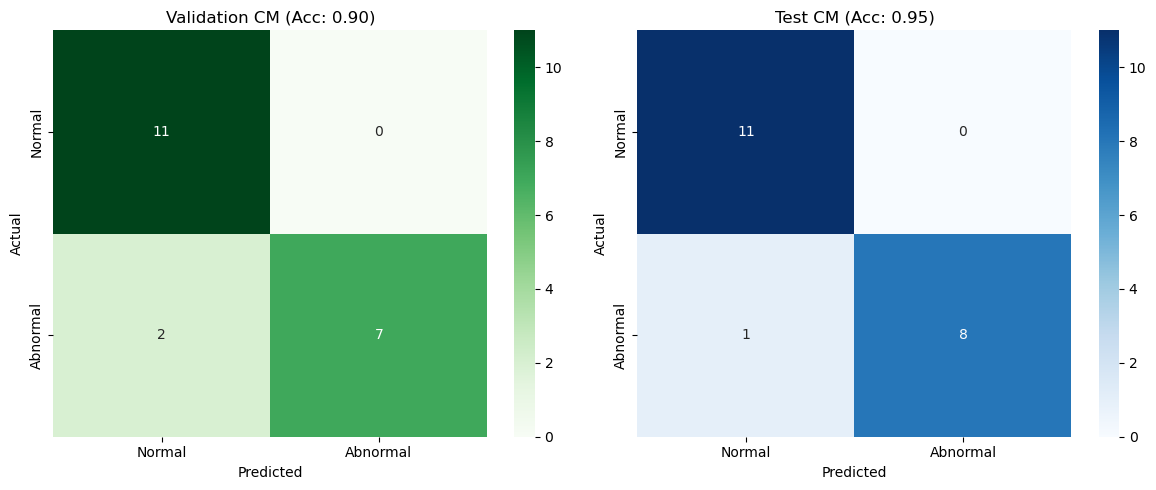

In [57]:
def evaluate_set(images, tabular, labels, set_name):
    probs = model.predict([images, tabular], verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    
    print(f"\n{'='*20} {set_name.upper()} REPORT {'='*20}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print(f"PR AUC:    {ap:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Normal', 'Abnormal']))
    
    return confusion_matrix(labels, preds), acc

cm_val, acc_val = evaluate_set(X_img_val, X_tab_val, y_val, "Validation")
cm_test, acc_test = evaluate_set(X_img_test, X_tab_test, y_test, "Test")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=ax[0],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[0].set_title(f'Validation CM (Acc: {acc_val:.2f})')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[1].set_title(f'Test CM (Acc: {acc_test:.2f})')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


In [54]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


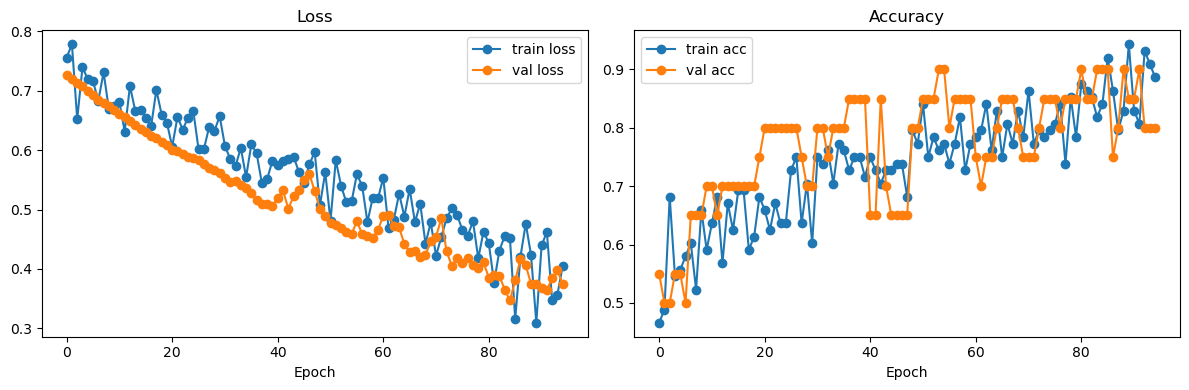

In [55]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()